<a href="https://colab.research.google.com/github/skredenmathias/DS-Unit-2-Applied-Modeling/blob/master/module1/assignment_applied_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

In [3]:
# I will use the worlds_2019 dataset for now.
import pandas as pd

!git clone https://github.com/skredenmathias/DS-Unit-1-Build.git
path = '/content/DS-Unit-1-Build/'
worlds_2019 = pd.read_excel(path+'2019-summer-match-data-OraclesElixir-2019-11-10.xlsx')
(print(worlds_2019.shape))
worlds_2019.head()

Cloning into 'DS-Unit-1-Build'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.
(1428, 98)


,gameid,url,league,split,date,week,game,patchno,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,k,d,a,teamkills,teamdeaths,doubles,triples,quadras,pentas,fb,fbassist,fbvictim,fbtime,kpm,okpm,ckpm,fd,fdtime,teamdragkills,...,fbarontime,teambaronkills,oppbaronkills,dmgtochamps,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,wardshare,wardkills,wcpm,visionwards,visionwardbuys,visiblewardclearrate,invisiblewardclearrate,totalgold,earnedgpm,goldspent,gspd,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,oppgoldat10,gdat10,goldat15,oppgoldat15,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
0,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,1,Blue,Top,Evi,DetonatioN FocusMe,Gnar,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,0,4,4,7,22,0,0,0,0,0,0,0,3.879983,0.000000,0.037688,1.092965,0,9.717567,1,...,23.779817,0,1,11588,436.733668,0.312067,0.206844,11,0.414573,0.105769,4,0.150754,4,6,,,8407,184.059799,8300,-0.151448,180,8,4,1,7.085427,3078,3440,-362,4670,5468,-798,4530,5051,-521,76,90,-14,116,122,-6
1,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,2,Blue,Jungle,Steal,DetonatioN FocusMe,Ekko,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,1,4,5,7,22,0,0,0,0,0,0,0,3.879983,0.037688,0.263819,1.092965,1,9.717567,1,...,23.779817,0,1,7925,298.680905,0.213422,0.166862,24,0.904523,0.230769,8,0.301508,11,13,,,7463,148.481910,7360,-0.296789,35,96,76,0,4.937186,3684,4055,-371,4912,6278,-1366,3679,3928,-249,60,64,-4,88,105,-17
2,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,3,Blue,Middle,Ceros,DetonatioN FocusMe,Nocturne,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,1,5,6,7,22,0,0,0,0,0,0,0,3.879983,0.037688,0.113065,1.092965,0,9.717567,1,...,23.779817,0,1,7557,284.811558,0.203512,0.210106,13,0.489950,0.125000,1,0.037688,6,7,,,8484,186.961809,7700,-0.281729,186,6,4,0,7.236181,3926,3569,357,5487,6116,-629,4751,4533,218,88,85,3,131,150,-19
3,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,4,Blue,ADC,Yutapon,DetonatioN FocusMe,Lucian,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,3,4,1,7,22,1,0,0,0,0,0,0,3.879983,0.113065,0.414573,1.092965,0,9.717567,1,...,23.779817,0,1,7369,277.726131,0.198449,0.300743,9,0.339196,0.086538,7,0.263819,3,4,,,10624,267.615075,10150,-0.215385,219,20,20,0,9.007538,3579,3969,-390,5313,7142,-1829,3526,3532,-6,87,76,11,119,134,-15
4,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,5,Blue,Support,Gaeng,DetonatioN FocusMe,Thresh,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,2,5,2,7,22,0,0,0,0,0,0,1,3.879983,0.075377,0.000000,1.092965,0,9.717567,1,...,23.779817,0,1,2694,101.532663,0.07255,0.115445,47,1.771357,0.451923,8,0.301508,13,14,,,6249,102.728141,5450,-0.296875,12,2,2,0,0.527638,2088,2394,-306,3163,4319,-1156,2731,2376,355,4,3,1,6,5,1


Choose your target. Which column in your tabular dataset will you predict?

In [0]:
df = worlds_2019
target = df['result']
# Initially I seek if I can predict if a team will win or lose.
# The goal is to see how much variance is explained by each factor.
# / see how much certain factors contribute to the result.

In [0]:
# From here I might look at questions such as:

# How do win conditions change per patch?

# What are the win percentages for red / blue side? Are different objectives
# more important to one side?

# See how different positions have different degrees of impact based on teams.

# 

Is your problem regression or classification?

In [0]:
# Classification.

 How is your target distributed?
Classification: How many classes? Are the classes imbalanced?

In [7]:
target.value_counts(normalize=True)

1    0.5
0    0.5
Name: result, dtype: float64

 Choose your evaluation metric(s).

Classification: Is your majority class frequency >= 50% and < 70% ? 
If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. 

What evaluation metric will you choose, in addition to or instead of accuracy?

In [0]:
# Accuracy. What others could I choose?

 Choose which observations you will use to train, validate, and test your model.

Are some observations outliers? Will you exclude them?

Will you do a random split or a time-based split?

In [0]:
# Difficult question. We will have to talk about this. I am contacting a close
# friend who's a League nerd & Data Scientist. Will be talking with him on
# Wednesday after class & assignments.

# Depends on ceteris paribus, other things equal:
# I might have to keep it on the same patch.
# Feature importances will differ across regions & tournaments & patches.
# Gamelength might be a leak?

# Should I also make a separate df with all 5 players grouped as a team w/
# most of the stats retained?

# Outliers:
# Gamelength beyond 50 minutes. I can filter these out if needed.

# Leaks / uninteresting columns:
# gameid, url, (league), (split), date, week, game, (patchno), playerid, 
# (position), (team), gamelength?, total gold?, firsttothreetowers?,
# teamtowerkills?, opptowerkills?, 

In [10]:
df.head()

,gameid,url,league,split,date,week,game,patchno,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,k,d,a,teamkills,teamdeaths,doubles,triples,quadras,pentas,fb,fbassist,fbvictim,fbtime,kpm,okpm,ckpm,fd,fdtime,teamdragkills,...,fbarontime,teambaronkills,oppbaronkills,dmgtochamps,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,wardshare,wardkills,wcpm,visionwards,visionwardbuys,visiblewardclearrate,invisiblewardclearrate,totalgold,earnedgpm,goldspent,gspd,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,oppgoldat10,gdat10,goldat15,oppgoldat15,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
0,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,1,Blue,Top,Evi,DetonatioN FocusMe,Gnar,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,0,4,4,7,22,0,0,0,0,0,0,0,3.879983,0.000000,0.037688,1.092965,0,9.717567,1,...,23.779817,0,1,11588,436.733668,0.312067,0.206844,11,0.414573,0.105769,4,0.150754,4,6,,,8407,184.059799,8300,-0.151448,180,8,4,1,7.085427,3078,3440,-362,4670,5468,-798,4530,5051,-521,76,90,-14,116,122,-6
1,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,2,Blue,Jungle,Steal,DetonatioN FocusMe,Ekko,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,1,4,5,7,22,0,0,0,0,0,0,0,3.879983,0.037688,0.263819,1.092965,1,9.717567,1,...,23.779817,0,1,7925,298.680905,0.213422,0.166862,24,0.904523,0.230769,8,0.301508,11,13,,,7463,148.481910,7360,-0.296789,35,96,76,0,4.937186,3684,4055,-371,4912,6278,-1366,3679,3928,-249,60,64,-4,88,105,-17
2,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,3,Blue,Middle,Ceros,DetonatioN FocusMe,Nocturne,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,1,5,6,7,22,0,0,0,0,0,0,0,3.879983,0.037688,0.113065,1.092965,0,9.717567,1,...,23.779817,0,1,7557,284.811558,0.203512,0.210106,13,0.489950,0.125000,1,0.037688,6,7,,,8484,186.961809,7700,-0.281729,186,6,4,0,7.236181,3926,3569,357,5487,6116,-629,4751,4533,218,88,85,3,131,150,-19
3,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,4,Blue,ADC,Yutapon,DetonatioN FocusMe,Lucian,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,3,4,1,7,22,1,0,0,0,0,0,0,3.879983,0.113065,0.414573,1.092965,0,9.717567,1,...,23.779817,0,1,7369,277.726131,0.198449,0.300743,9,0.339196,0.086538,7,0.263819,3,4,,,10624,267.615075,10150,-0.215385,219,20,20,0,9.007538,3579,3969,-390,5313,7142,-1829,3526,3532,-6,87,76,11,119,134,-15
4,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.286146,PI-RR,1,9.19,5,Blue,Support,Gaeng,DetonatioN FocusMe,Thresh,Qiyana,Gangplank,Akali,Elise,Olaf,26.533333,0,2,5,2,7,22,0,0,0,0,0,0,1,3.879983,0.075377,0.000000,1.092965,0,9.717567,1,...,23.779817,0,1,2694,101.532663,0.07255,0.115445,47,1.771357,0.451923,8,0.301508,13,14,,,6249,102.728141,5450,-0.296875,12,2,2,0,0.527638,2088,2394,-306,3163,4319,-1156,2731,2376,355,4,3,1,6,5,1


In [11]:
df.columns

Index(['gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno',
       'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1',
       'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas',
       'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd',
       'fdtime', 'teamdragkills', 'oppdragkills', 'elementals',
       'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes',
       'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft',
       'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
       'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'visiblewardclearrate',
       'invisiblewardclearrate', 'totalgold', 'earnedg

 Begin to clean and explore your data.

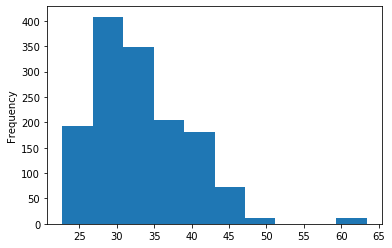

In [12]:
# Lot's of cleaning done in the unit 1 build notebook.
# Will focus on exploration here for now.

df['gamelength'].plot.hist() # We see a small outlier here.

In [13]:
df['gamelength'].describe()

count    1428.000000
mean       33.292857
std         6.435920
min        22.716667
25%        28.483333
50%        32.083333
75%        37.583333
max        63.416667
Name: gamelength, dtype: float64

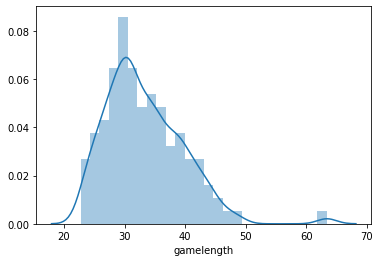

In [14]:
import seaborn as sns
# Note: Will be other outliers in the big dataset.
# Couldn't upload full dataset to Git, 80mb is too big.
# Why is it so big, it's just a text file?
sns.distplot(df['gamelength']);

# Fast first model

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=.25)

In [0]:
!pip install category_encoders
import category_encoders as ce

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [0]:
target = 'result'

In [0]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
# X_test = test.drop(columns=target)
# y_test = test[target]

In [24]:
X_train.shape, X_val.shape

((1071, 97), (357, 97))

In [25]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['url', 'league', 'split', 'week', 'game',
                                      'side', 'position', 'player', 'team',
                                      'champion', 'ban1', 'ban2', 'ban3',
                                      'ban4', 'ban5', 'doubles', 'triples',
                                      'quadras', 'pentas', 'dmgshare',
                                      'earnedgoldshare', 'visiblewardclearrate',
                                      'invisiblewardclearrate'],
                                drop_invariant=False, handle_missing='value',
                                handl...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

In [29]:
# Get validation accuracy
y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', pipeline.score(X_val, y_val)) # We've got leakage!

Validation Accuracy: 0.9971988795518207


In [32]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

print('X_train shape after encoding', encoded.shape)

X_train shape before encoding (1071, 97)
X_train shape after encoding (1071, 97)


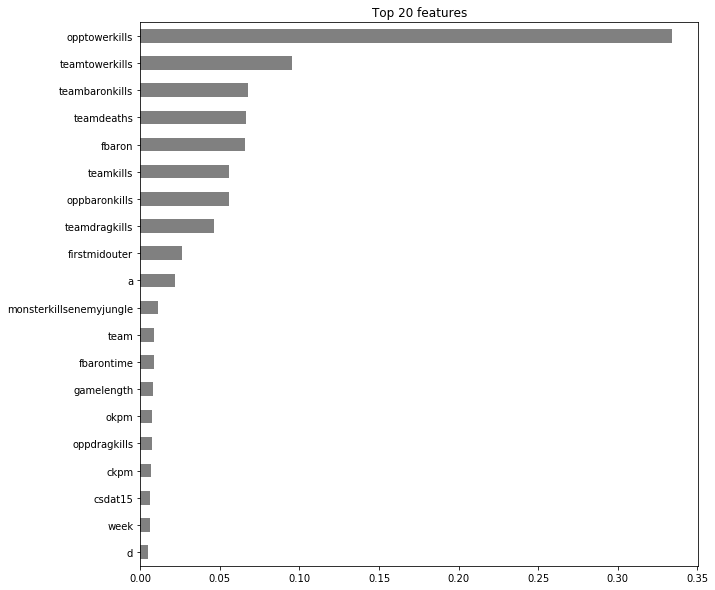

In [33]:
# Plot feature importances to find leak
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')